In [1]:
import flopy; import sys; import pathlib; import os; import time; import numpy as np; import matplotlib.pyplot as plt
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\08')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'macrodispersion_illustration'           ;  workdir = os.path.join('.', directory_name)
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
folder_w_datafile = ('E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\data_for_models')

E:\15_REPOS\00_BETAMI\w10_______others\06_MT3D_Wisconsin-Madison\00


In [2]:
datafile_name = 'anisotropic_perm_field_sig100.csv'
data_file_with_path = os.path.join(folder_w_datafile, datafile_name)              ; kdata_m2 = np.loadtxt(data_file_with_path, delimiter=',')
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; print('Vector = ', kdata_m2.shape)   
hk_weak    = rawk_m2*(1000*9.81*100/8.9E-4)                                          # Permeabiltiy (in m^2) to K (cm/sec)
datafile_name = 'anisotropic_perm_field_sig100000.csv'
data_file_with_path = os.path.join(folder_w_datafile, datafile_name)              ; kdata_m2 = np.loadtxt(data_file_with_path, delimiter=',')
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; print('Vector = ', kdata_m2.shape)   
hk_strong  = rawk_m2*(1000*9.81*100/8.9E-4)   
geo_mean_weak   = np.exp(np.sum(np.log(hk_weak))   / hk_weak.size)                ; print('K=', geo_mean_weak, 'cm/sec')
geo_mean_strong = np.exp(np.sum(np.log(hk_strong)) / hk_strong.size)              ; print('K=', geo_mean_strong, 'cm/sec')

Nrows = 20 Ncolumns = 40
Vector =  (800,)
Nrows = 20 Ncolumns = 40
Vector =  (800,)
K= 0.0005412218263527298 cm/sec
K= 0.0007188879381530694 cm/sec


In [3]:
# Grid size (cm)
grid_size = [0.25, 0.25]
Lx = (ncol - 1) * grid_size[1]   # length of model in selected units 
Ly = (nrow - 1) * grid_size[0]   # length of model in selected units 
y, x = np.mgrid[slice(0, Ly + grid_size[0], grid_size[0]),
                slice(0, Lx + grid_size[1], grid_size[1])]


def plot_2d(map_data, X, Y, cmap, colorbar_label, title_text):
    # define figure and with specificed resolution (by adjusting dpi)
    plt.figure(figsize=(10, 3), dpi=150)
    plt.pcolor(X, Y, map_data, cmap=cmap, shading = 'auto', edgecolor ='k', linewidth = 0.2)
    plt.gca().set_aspect('equal')  
    # add a colorbar
    cbar = plt.colorbar() 
    # label the colorbar
    cbar.set_label(colorbar_label)
    plt.title(title_text)

Plot the conductivity filed to make sure it looks reasonable.

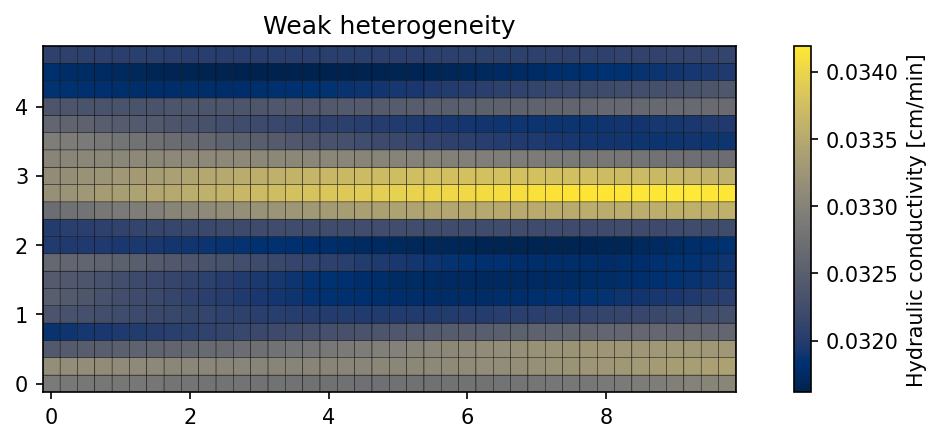

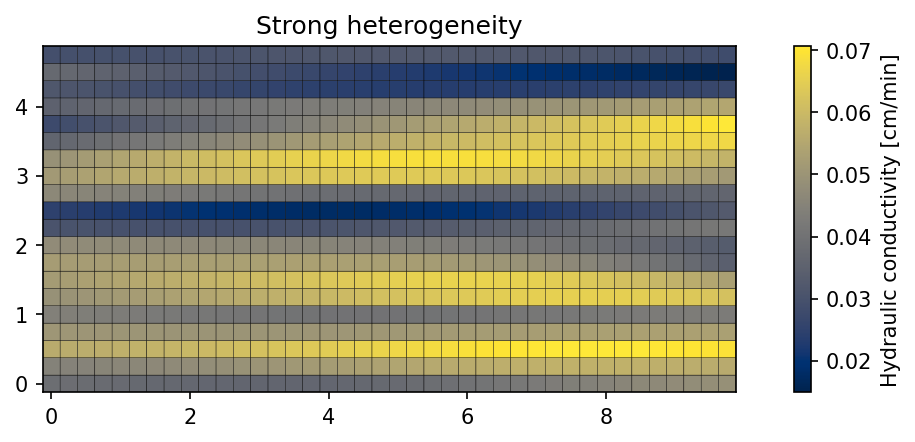

In [4]:
# If you want to have some fun with colormaps, import the crameri colormaps 
# from cmcrameri import cm
# replace 'cividis' with cm.hawaii for example. All available colormaps are available here: https://www.fabiocrameri.ch/colourmaps/

# Plot weak anistropy field
plot_2d(hk_weak[0,:,:]*60, x, y, 'cividis', 'Hydraulic conductivity [cm/min]', 'Weak heterogeneity')

# Plot strong anistropy field
plot_2d(hk_strong[0,:,:]*60, x, y, 'cividis', 'Hydraulic conductivity [cm/min]', 'Strong heterogeneity')

#### How are these conductivity fields similiar and how are they different? Make sure to note the different colorbar ranges.

## 2D Model Function with Heterogeneous Conductivity Field
The first thing we do is setup the function. We will use nearly identical settings as the [FloPy 1D Function](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%201D%20Function.ipynb), but we are changing up a few of the input variables. The input variables are:

### Function Input:
#### directory name
    direname = 

#### MT3D period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). Note that this is different from the MODFLOW flow model period input. Therefore the underlying flow conditions are constant and steady state across changes in MT3D stress periods. The format for multi-period input: ```[time_of_pulse_injection, time_of_rest_of_model]```

The function is set up to only allow for two input periods. For example:
 
    perlen_mt = [60, 60*58]
    
#### hydraulic conductivity
The hydraulic conductivity needs to be in the selected units (cm/s in this model) and can be either a scalar (homogeneous model) or matrix with the dimensions of the model (or vector if the model is 1D).
```python
hk = hk_value*np.ones([1, hk_size[1], hk_size[2]])
```

    hk = 
    
#### advection velocity
Note that this is only an approximate advection flow rate in due to the way that the inlet boundary conditions are being assigned in the MODFLOW BAS6 - Basic Package. More rigorous constraint of constant flux boundaries require the Flow and Head Boundary Package, the Well Package, or the Recharge Package.

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
    
#### itype
An integer indicating the type of solute source condition. itype = -1 corresponds to a constant concentration boundary (first-type boundary conditions in our analytical solutions) and itype = 1 is equivalent to third type boundary conditions in our analytical solution.  

    itype = 
    

## Run three different numerical models

In [5]:
def model_2D(dirname, perlen_mt, hk, v, al, trpt, itype):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # Modflow stress periods
    perlen_mf = [np.sum(perlen_mt)]
    # number of stress periods (MF input), calculated from period length input
    nper_mf = len(perlen_mf)
    
    # number of stress periods (MT input), calculated from period length input
    nper = len(perlen_mt)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    hk_size = hk.shape
    nlay = hk_size[0] # number of layers
    nrow = hk_size[1] # number of rows
    ncol = hk_size[2] # number of columns
    delr = 0.25 # grid size in direction of Lx
    delc = 1.0 # grid size in direction of Ly, 
    delv = 0.25 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")
    
    # hydraulic conductivity
    geo_mean_k = np.exp(np.sum(np.log(hk))/hk.size)
    # porosity
    prsity = 0.3
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    # index the inlet cell
    ibound[0, :, 0] = -1
    # index the outlet cell
    ibound[0, :, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx/geo_mean_k
    # index the inlet cell
    strt[0, :, 0] = h1
    print("Inlet head value: " + str(h1) + " (check units of 'lenuni')")
    
    # Solute transport boundary conditions
    # Concentration at inlet boundary
    C_in = [1.0, 0.0]

    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=int)

    # Initial conditions: concentration zero everywhere
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    
    # MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
    # This is used as input for the source and sink mixing package
    # Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
    itype = itype
    cwell_info = np.zeros((nrow, 5), dtype=float)
    # Nested loop to define every inlet face grid cell as a well
    for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype] 
            
    # Second stress period        
    cwell_info2 = cwell_info.copy()   
    cwell_info2[:,3] = C_in[1] 
    # Now apply stress period info    
    spd_mt = {0:cwell_info, 1:cwell_info2}
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    # MODFLOW output control package
    oc = flopy.modflow.ModflowOc(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    # Extract head information
    fname = os.path.join(model_ws, modelname_mf+'.hds')
    hdobj = flopy.utils.HeadFile(fname)
    heads = hdobj.get_data()
    
    # Extract the 4D concentration values (t, x, y, z)
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc, heads

Ok, now we are ready to run some models! Let's first run the model with the homogeneous permeability field.

In [6]:
# Define homogeneous conductivity field equal to the geometric mean of the weakly anisotropic field
hk_hom = geo_mean_weak*np.ones([1, 20, 40])

# Directory name
dirname = 'homogeneous_2D'
# Length of model run
perlen_mt = [60*3, 60*58]
v = 0.01
al = 0.2 # cm
itype = -1
trpt = 0.1
# RUN model!
    
mf, mt, times, conc, heads = model_2D(dirname, perlen_mt, hk_hom, v, al, trpt, itype)

.\macrodispersion_illustration\homogeneous_2D
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 54.04438360720681 (check units of 'lenuni')


Up to now, we have only seen 1D models. We call these 1D models because the parameters vary in only one spatial dimension so the other two dimensions have a size of 1. Let's double check that the dimensions of this model are 2D. That means we expect a time dimension equal to the variable 'nprs' + 1 from our FloPy function, 1 layer, and what are the lengths of the other two dimensions?

In [7]:
# Let's check your answer
np.shape(conc)

(102, 1, 20, 40)

See how the dimensions of the concentration output relate to the size of the model (as defined by the size of our conductivity field)?

Next, let's use the plotting function to plot the 2D concentration distribution at one instant in time.

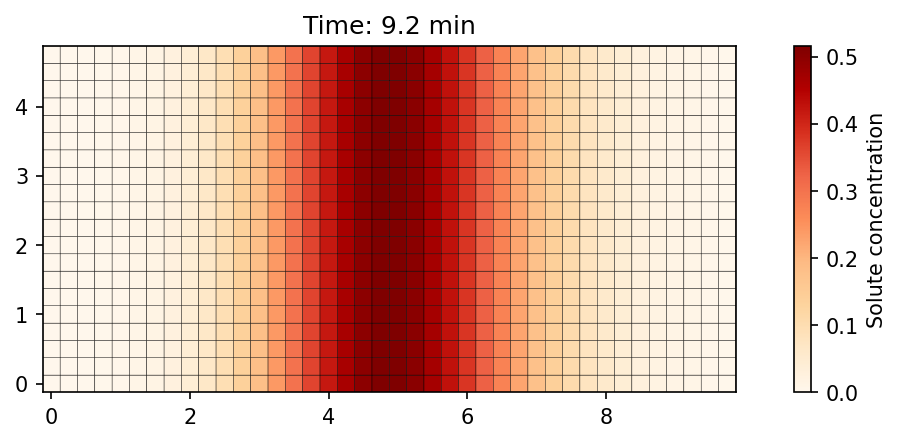

In [8]:
# define timestep to plot data
time_step = 16
colorbar_label = 'Solute concentration'
plot_title = 'Time: %1.1f min' %(times[time_step]/60)

# Call our 2D plot function to plot the concentration map at a specific time
plot_2d(conc[time_step,0,:,:], x, y,  'OrRd', colorbar_label, plot_title)

Now run the model with the weak anisotropy permeability field.

In [9]:
# Directory name
dirname = 'anisotropic_weak'
# RUN!
mf, mt, times_w, conc_weak, heads = model_2D(dirname, perlen_mt, hk_weak, v, al, trpt, itype)

.\macrodispersion_illustration\anisotropic_weak
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 54.04438360720681 (check units of 'lenuni')


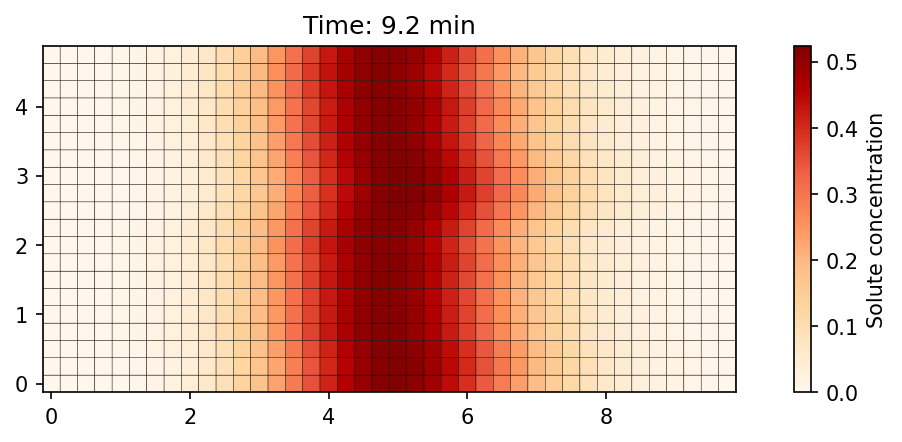

In [10]:
# Now let's call our plotting function
plot_2d(conc_weak[time_step,0,:,:], x, y,  'OrRd', colorbar_label, plot_title)

Now let's again run the identical model, the only difference is the permeability field anisotropy is 100x stronger (as defined by the standard deviation of the permeability field).

In [11]:
# Directory name
dirname = 'anisotropic_strong'
# RUN!
mf, mt, times_s, conc_strong, heads = model_2D(dirname, perlen_mt, hk_strong, v, al, trpt, itype)

.\macrodispersion_illustration\anisotropic_strong
Model length is: 10.0 (check units of 'lenuni')
Inlet head value: 40.687843609043746 (check units of 'lenuni')


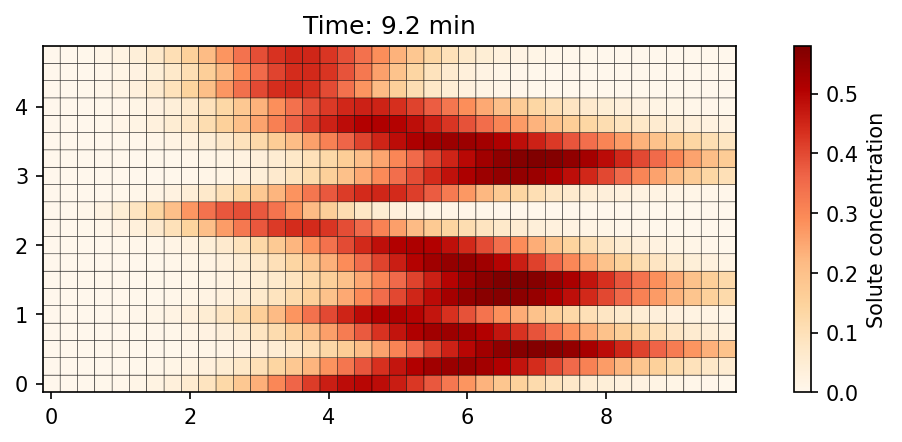

In [12]:
# Call our plotting function again
plot_2d(conc_strong[time_step,0,:,:], x, y,  'OrRd', colorbar_label, plot_title)

# Plot the heads. Before running, what do you expect these to look like??
# head_colorbar_label = 'Head [cm]'
# plot_title_head = 'Steady-state head'
# plot_2d(np.squeeze(heads), x, y,  'Blues', head_colorbar_label, plot_title_head)


Explain what is going on here. Why is the solute further from the inlet in some areas and closer to the inlet in other areas of the model?

## Activity:
Using a combination of analytical solutions and moment analysis, let's calculate the macrodispersion of the strongly anisotropic heterogenous numerical model. This macrodispersion is the dispersion or dispersivity necessary to capture the spreading in a 1D model that doesn't account for or quantify the heterogenity-driven dispersion in the more complex 2D model.

To begin, we need to define a function to calculate the analytical solution with boundary and initial conditions that correspond to our numerical model.

### Compare numerical model results with analytical solution

In [13]:
# Remember that we need a few special functions
from scipy.special import erfc as erfc
from scipy.special import erf as erf

# Type 1 inlet conditions, finite length solution
def analytical_model_1D_finite_t1(x, t, v, al, L):
    # Dispersion
    D = v*al
    
    # Identify location of negative values in time array
    indices_below_zero = t <= 0
    
#     print(indices_below_zero)
    if indices_below_zero.any() == True:
        # set values equal to 1 (but this could be anything)
        t[indices_below_zero] = 1
    
    # Analytical solution: Analytical solution based on Equation A3 in van Genuchtena and Alves, 1982.
    # Note that the '\' means continued on the next line
    C = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*(2 + (v*(2*L - x)/D) + v**2*t/D)* \
        np.exp(v*L/D)*erfc(((2*L - x)+ v*t)/(2*np.sqrt(D*t))) - \
        (v**2 *t/(3.1415*D))**(1/2) * np.exp(v*L/D - ((2*L - x + v*t)**2)/(4*D*t))
    
    if indices_below_zero.any() == True:
        # Now set concentration at those negative times equal to 0
        C[indices_below_zero] = 0
    
    # Return the concentration (C) from this function
    return C

What are the boundary conditions (both inlet and outlet) of the function we just defined? Think through why these are the correct boundary conditions to compare with out numerical model.

In [14]:
# Extract grid
ym, xm, zm = mf.dis.get_node_coordinates()
# We want to plot along x so let's print x to make sure this looks right
print(xm)

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 2.125 2.375 2.625 2.875
 3.125 3.375 3.625 3.875 4.125 4.375 4.625 4.875 5.125 5.375 5.625 5.875
 6.125 6.375 6.625 6.875 7.125 7.375 7.625 7.875 8.125 8.375 8.625 8.875
 9.125 9.375 9.625 9.875]


Using this grid location information, we can plug this into the analytical solution to calculate concentrations analytically at these same grid cell locations.

In [15]:
# Call the analytical model function
Conc_time_type1_t = analytical_model_1D_finite_t1(xm[-1], times, v, al, xm[-1])
# Call it again to use superposition to model a pulse
# Define the time array shifted by the length of pulse injection.
# The length of the pulse injection is defined by the length of the second stress period
t_t0 = times - perlen_mt[0]
Conc_time_type1_t_t0 = analytical_model_1D_finite_t1(xm[-1], t_t0, v, al, xm[-1])

Conc_pulse_solution = Conc_time_type1_t - Conc_time_type1_t_t0

In [16]:
# Extract the breakthrough time at the outlet
C_btc_h = np.mean([conc[:, 0, :, -1]], axis=2)
C_btc_w = np.mean([conc_weak[:, 0, :, -1]], axis=2)
C_btc_s = np.mean([conc_strong[:, 0, :, -1]], axis=2)

Plot the numerical and analytical models

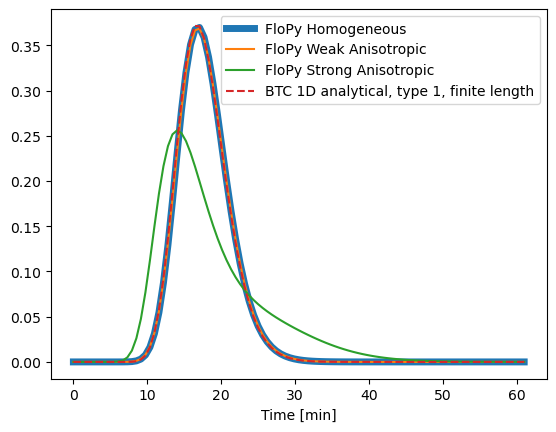

In [17]:
plt.plot(times/60, np.transpose(C_btc_h), linewidth = 5, label='FloPy Homogeneous')
plt.plot(times_w/60, np.transpose(C_btc_w), label='FloPy Weak Anisotropic')
plt.plot(times_s/60, np.transpose(C_btc_s), label='FloPy Strong Anisotropic')
plt.plot(times/60, Conc_pulse_solution, '--', label='BTC 1D analytical, type 1, finite length')
# add xlabel and lengend
plt.xlabel('Time [min]')
plt.legend()
plt.show()

So far so good, the analytical model matches some of the numerical models. Why does it not match the strongly anisotropic field model output?

For spatial moment analysis we want to evalute concentration distributions or concentration profiles so now let's compare the numerical models with analytical solutions as a function of space rather than as a function of time.

Model time: 5.48999989827474 min


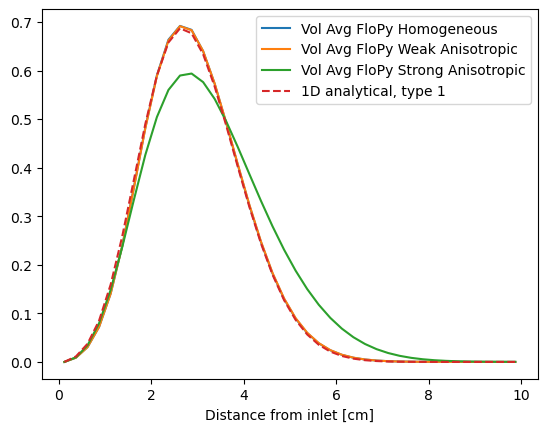

In [18]:
# Plot concentration profiles
# Choose a timestep to evaluate the analytical solution at
timestep = 10
# Note that this timestep corresponds to the numerical model output increment, the actual model time is given by
print('Model time: ' + str(times[timestep]/60) + ' min')

C_profile_h = np.mean([conc[timestep, 0, :, :]], axis=1)
C_profile_w = np.mean([conc_weak[timestep, 0, :, :]], axis=1)
C_profile_s = np.mean([conc_strong[timestep, 0, :, :]], axis=1)

# Call the analytical model function 
# Note that the spatial coordinates need to be shifted to start from zero for accurate comparison with the numerical model
Conc_time_type1_x = analytical_model_1D_finite_t1(xm-xm[0], times[timestep], v, al, xm[-1])
# Call it again to use superposition to model a pulse
time_t0 = times[timestep] - perlen_mt[0]
Conc_time_type1_x_t0 = analytical_model_1D_finite_t1(xm-xm[0], time_t0, v, al, xm[-1])
# Superimpose the two solutions
Conc_pulse_solution_in_space = Conc_time_type1_x - Conc_time_type1_x_t0

plt.plot(xm, np.transpose(C_profile_h), label='Vol Avg FloPy Homogeneous')
plt.plot(xm, np.transpose(C_profile_w), label='Vol Avg FloPy Weak Anisotropic')
plt.plot(xm, np.transpose(C_profile_s), label='Vol Avg FloPy Strong Anisotropic')
plt.plot(xm, Conc_pulse_solution_in_space, '--', label='1D analytical, type 1')
plt.xlabel('Distance from inlet [cm]')
plt.legend()
plt.show()

### Spatial moment analysis
Using moment analysis, let's calculate the macrodispersion of the strongly anisotropic heterogenous numerical model. First, define a function that can be used to efficiently calculate different spatial moments. Since we are only intersted in quantifying longitudinal dispersion, we don't need to perform a fully 3D moment analysis and can simply calculate spatial moments in the x-direction.

In [19]:
def spatial_moment_calc(conc, timestep): ############## BUUUUUGGG X
    # Sum of all tracer in core at timestep when all tracer is in the core (zero moment)
    C_x = np.sum([conc[timestep, 0, :, :]], axis=1)
    Mx0 = np.trapz(C_x, xm)
    print('Zero moment = ' + str(Mx0))
    # First spatial moment
    Mx1 = np.trapz(xm*C_x, xm)
    # Center of mass equation
    x_bar = Mx1/Mx0
    
    print('Center of mass = ' + str(x_bar) + ' cm')
    # Second spatial moment
    # Mx2 = # FILL THIS IN
    
    var = 0 # FILL THIS IN
    
    return x_bar, var

In [20]:
# Call function at a given timestep
x_bar1, var1 = spatial_moment_calc(conc_strong, timestep)
# Call function at a later timestep
x_bar2, var2 = spatial_moment_calc(conc_strong, timestep+1)

# Now use equation from class to calculate the value of the macrodispersion
# 0 # FILL THIS IN
print(D_macro)
# Calculate dispersivity for analytical solution
al_macro = D_macro/v
print(al_macro)

Zero moment = [37.9061]
Center of mass = [3.2612863] cm
Zero moment = [37.87111]
Center of mass = [3.6800745] cm


C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value in

NameError: name 'D_macro' is not defined

Your value of macrodispersivity should be larger than the dispersivity (```al```) defined above, but of the same order of magnitude. 

In [ ]:
# Call the analytical model function with the macrodispersivity
# Conc_pulse_solution_in_space = 
al_macro =0.4
Conc_time_type1_x = analytical_model_1D_finite_t1(xm-xm[0], times[timestep], v, al_macro, xm[-1])
# Call it again to use superposition to model a pulse
time_t0 = times[timestep] - perlen_mt[0]
Conc_time_type1_x_t0 = analytical_model_1D_finite_t1(xm-xm[0], time_t0, v, al_macro, xm[-1])
# Superimpose the two solutions
Conc_pulse_solution_in_space_macro = Conc_time_type1_x - Conc_time_type1_x_t0

In [ ]:
# Now plot them again and compare
plt.plot(xm, np.transpose(C_profile_s), label='Vol Avg FloPy Strong Anisotropic')
plt.plot(xm, Conc_pulse_solution_in_space_macro, '--', label='1D Analytical Macrodispersion')
plt.plot(xm, Conc_pulse_solution_in_space, '--', label='1D Analytical w/dispersivity of numerical model')
# plt.plot([x_bar1, x_bar1], [0, 1], 'k:', label='Center of mass (FloPy)')

plt.xlabel('Distance from inlet [cm]')
plt.legend()

In [ ]:
# Call the analytical model function
Conc_time_type1_t = analytical_model_1D_finite_t1(xm[-1], times, v, al_macro, xm[-1])
# Call it again to use superposition to model a pulse
# Define the time array shifted by the length of pulse injection.
# The length of the pulse injection is defined by the length of the second stress period
t_t0 = times - perlen_mt[0]
Conc_time_type1_t_t0 = analytical_model_1D_finite_t1(xm[-1], t_t0, v, al_macro, xm[-1])

Conc_pulse_solution_macro = Conc_time_type1_t - Conc_time_type1_t_t0

plt.plot(times/60, np.transpose(C_btc_h), linewidth = 5, label='FloPy Homogeneous')
plt.plot(times/60, Conc_pulse_solution_macro, label='BTC 1D analytical macro')
plt.plot(times_s/60, np.transpose(C_btc_s), label='FloPy Strong Anisotropic')
plt.plot(times/60, Conc_pulse_solution, '--', label='BTC 1D analytical, type 1, finite length')
# add xlabel and lengend
plt.xlabel('Time [min]')
plt.legend()

With a partner, discuss these results. Why does the 1D analytical model with a larger dispersivity better match the heterogeneous numerical model than the analytical model with identical dispersivity input as the numerical model?